In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, datasets

import time

from torchsummary import summary

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [7]:
batch_size = 256

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def swish(x):
    return x * x.sigmoid()

def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul_(mask)
    return x


class SE(nn.Module):
    '''Squeeze-and-Excitation block with Swish.'''

    def __init__(self, in_channels, se_channels):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_channels, se_channels,
                             kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_channels, in_channels,
                             kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    '''expansion + depthwise + pointwise + squeeze-excitation'''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.,
                 drop_rate=0.):
        super(Block, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        # Expansion
        channels = expand_ratio * in_channels
        self.conv1 = nn.Conv2d(in_channels,
                               channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        # Depthwise conv
        self.conv2 = nn.Conv2d(channels,
                               channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=channels,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        # SE layers
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)

        # Output
        self.conv3 = nn.Conv2d(channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection if in and out shapes are the same (MV-V2 style)
        self.has_skip = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels,
                          out_channels,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out


def EfficientNetB0():
    cfg = {
        'num_blocks': [1, 2, 2, 3, 3, 4, 1],
        'expansion': [1, 6, 6, 6, 6, 6, 6],
        'out_channels': [16, 24, 40, 80, 112, 192, 320],
        'kernel_size': [3, 3, 5, 3, 5, 5, 3],
        'stride': [1, 2, 2, 2, 1, 2, 1],
        'dropout_rate': 0.2,
        'drop_connect_rate': 0.2,
    }
    return EfficientNet(cfg)


In [10]:
output_class = 10
net = EfficientNetB0().to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [11]:
summary(net, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          864
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─Sequential: 1-3                        [-1, 320, 2, 2]           --
|    └─Block: 2-1                        [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 32, 32]          64
|    |    └─SE: 3-3                      [-1, 32, 32, 32]          552
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          512
|    |    └─BatchNorm2d: 3-5             [-1, 16, 32, 32]          32
|    └─Block: 2-2                        [-1, 24, 16, 16]          --
|    |    └─Conv2d: 3-6                  [-1, 96, 32, 32]          1,536
|    |    └─BatchNorm2d: 3-7             [-1, 96, 32, 32]          192
|    |    └─Conv2d: 3-8                  [-1, 96, 16, 16]          864
|    |

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          864
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─Sequential: 1-3                        [-1, 320, 2, 2]           --
|    └─Block: 2-1                        [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 32, 32]          64
|    |    └─SE: 3-3                      [-1, 32, 32, 32]          552
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          512
|    |    └─BatchNorm2d: 3-5             [-1, 16, 32, 32]          32
|    └─Block: 2-2                        [-1, 24, 16, 16]          --
|    |    └─Conv2d: 3-6                  [-1, 96, 32, 32]          1,536
|    |    └─BatchNorm2d: 3-7             [-1, 96, 32, 32]          192
|    |    └─Conv2d: 3-8                  [-1, 96, 16, 16]          864
|    |

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, min_lr=1e-5)

In [10]:
num_epochs = 150
train_loss_lst = []
train_acc_lst = []
test_loss_lst= []
test_acc_lst= []

In [12]:
for epoch in range(1, num_epochs+1):

    since = time.time()

    train_loss = 0
    train_correct = 0
    train_total = 0
    
    net.train()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        
    train_loss_lst.append(train_loss/len(trainloader))
    train_acc_lst.append(100.*train_correct/train_total)


    test_loss = 0
    test_correct = 0
    test_total = 0

    net.eval()
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

        scheduler.step(test_loss)

        test_loss_lst.append(test_loss/len(testloader))
        test_acc_lst.append(100.*test_correct/test_total)

    time_elapsed = time.time() - since    

    print(f'Epoch: {epoch} | Time: {int(time_elapsed)}s | Train Loss: {train_loss_lst[-1]:.5f} | Train Acc: {train_acc_lst[-1]:.2f}% | Test Loss: {test_loss_lst[-1]:.5f} | Test Acc: {test_acc_lst[-1]:.2f}%')

    

Epoch: 1 | Time: 23s | Train Loss: 1.83050 | Train Acc: 31.05% | Test Loss: 1.67980 | Test Acc: 37.48%
Epoch: 2 | Time: 23s | Train Loss: 1.67281 | Train Acc: 37.51% | Test Loss: 1.55333 | Test Acc: 41.65%
Epoch: 3 | Time: 23s | Train Loss: 1.56037 | Train Acc: 41.92% | Test Loss: 1.45221 | Test Acc: 45.86%
Epoch: 4 | Time: 23s | Train Loss: 1.47865 | Train Acc: 45.28% | Test Loss: 1.38565 | Test Acc: 48.76%
Epoch: 5 | Time: 23s | Train Loss: 1.40872 | Train Acc: 48.24% | Test Loss: 1.31392 | Test Acc: 51.82%
Epoch: 6 | Time: 23s | Train Loss: 1.35084 | Train Acc: 50.76% | Test Loss: 1.27068 | Test Acc: 53.96%
Epoch: 7 | Time: 23s | Train Loss: 1.29413 | Train Acc: 52.83% | Test Loss: 1.21805 | Test Acc: 56.00%
Epoch: 8 | Time: 23s | Train Loss: 1.24386 | Train Acc: 54.76% | Test Loss: 1.17611 | Test Acc: 57.42%
Epoch: 9 | Time: 23s | Train Loss: 1.19827 | Train Acc: 56.68% | Test Loss: 1.12430 | Test Acc: 59.52%
Epoch: 10 | Time: 23s | Train Loss: 1.15849 | Train Acc: 58.29% | Test Lo

151

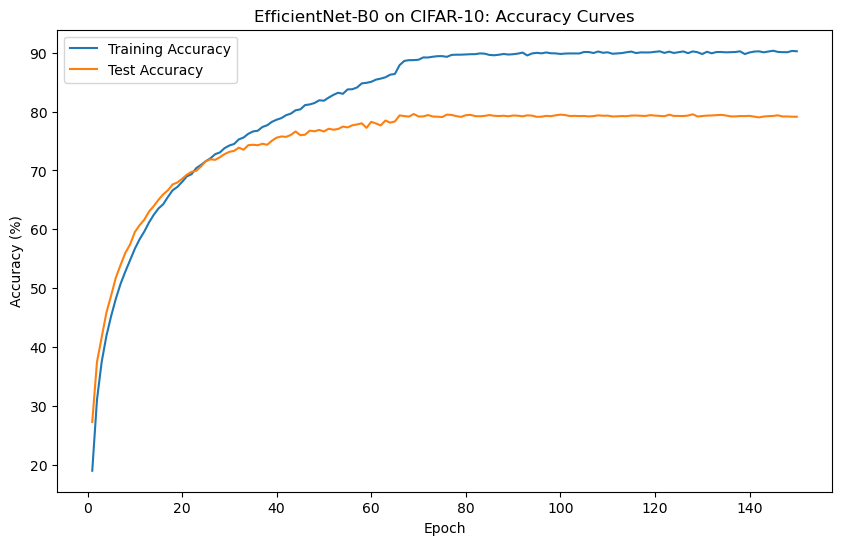

In [17]:
import matplotlib.pyplot as plt

# Plot the training and test accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_acc_lst[:150], label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_lst[:150], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('EfficientNet-B0 on CIFAR-10: Accuracy Curves')
plt.legend()
plt.show()

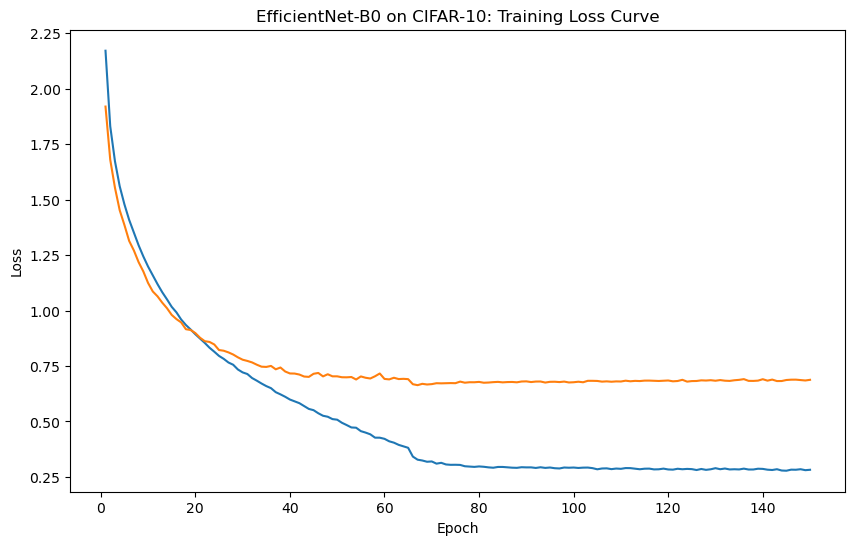

In [20]:
# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_lst[:150], label='Training Loss')
plt.plot(range(1, num_epochs+1), test_loss_lst[:150], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNet-B0 on CIFAR-10: Training Loss Curve')
plt.show()

In [19]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.inference_mode():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82.50 %
Accuracy of   car : 88.80 %
Accuracy of  bird : 70.00 %
Accuracy of   cat : 58.90 %
Accuracy of  deer : 76.50 %
Accuracy of   dog : 72.90 %
Accuracy of  frog : 84.40 %
Accuracy of horse : 81.50 %
Accuracy of  ship : 89.60 %
Accuracy of truck : 86.50 %


In [21]:
from itertools import product


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.inference_mode():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                num = conf_mat[i, j].astype(np.int64) 
                cell_text += format(num, 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

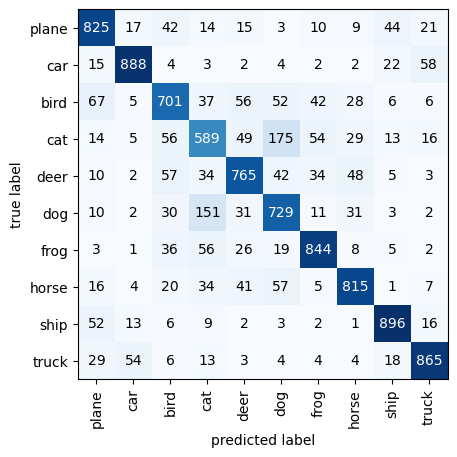

In [22]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net.to('cpu'), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=classes)
plt.show()